## Contents
-  [1.Importing Libraries](#1)
-  [2.Dataset Managament](#2)
    -  [2.1.Pytorch Dataset](#2.1)
    -  [2.2.Pytorch DataLoaders](#2.2)
-  [3.Creating a CNN-Siamese Model](#3)
-  [4.Training](#4)
-  [5.Plotting Graphs](#5)
    -  [5.1.Plotting Loss vs Epoch](#5.1)
    -  [5.2.Plotting Accuracy vs Epoch](#5.2)
-  [6.Loading and Testing](#6)

### 1.Importing Libraries <a class="anchor" id="1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset as Dataset
from torch.utils.data import DataLoader as DataLoader
import torch.optim as optim
import torchvision.transforms as T
import seaborn as sns
import os
import random
from PIL import Image

sns.set_style('darkgrid')

### 2.Dataset Managament <a class="anchor" id="2"></a>

#### 1.Pytorch Datasets<a class="anchor" id="2.1"></a>

In [2]:
class mnist_dataset_train(Dataset):
    def __init__(self,transforms):
        path = 'data/train_data/'
        self.transforms = transforms
        self.data = []
        self.len = 0
        for i in range(10):
            temp = []
            for j in os.listdir(path+'/'+str(i)):
                self.len +=1
                temp.append(Image.open(path+str(i)+'/'+j))
            self.data.append(temp)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        img1 , img2 , label = None , None , 1
        if idx%2 == 0: # same img
            n = random.randrange(0,10)
            img1 = self.data[n][random.randrange(0,11)]
            img2 = self.data[n][random.randrange(0,11)]
    
        
        else:
            n = random.randrange(0,10)
            img1 = self.data[n][random.randrange(0,11)]
            n = random.randrange(0,10)
            img2 = self.data[n][random.randrange(0,11)]
            label = 0
        
        return self.transforms(img1) , self.transforms(img2) , torch.FloatTensor([label])
    

class mnist_dataset_test(Dataset):
    def __init__(self,transforms):
        path = 'data/test_data/'
        self.transforms = transforms
        self.data = []
        self.len = len(os.listdir(path))
        for i in os.listdir(path):
            self.data.append(Image.open(path+i))
        
    def __len__(self):
        return self.len
    
    def __getitem__(self,idx):
        img1 = self.data[idx]
        
        return self.transforms(img1)

#### 2.Pytorch DataLoaders<a class="anchor" id="2.2"></a>

In [3]:
train_transforms = T.Compose([T.RandomRotation(degrees=(-45,45)),
                            T.ToTensor()
])

test_transforms = T.Compose([T.ToTensor()])

train_dataset = mnist_dataset_train(transforms = train_transforms)
test_dataset = mnist_dataset_test(transforms = test_transforms)
train_dataloader = DataLoader(train_dataset,32)


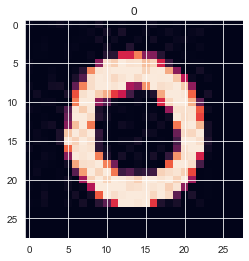

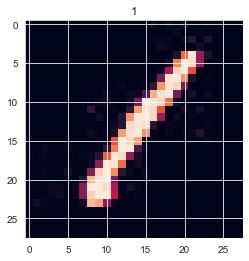

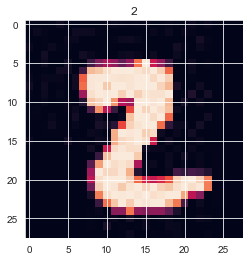

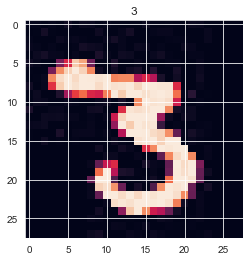

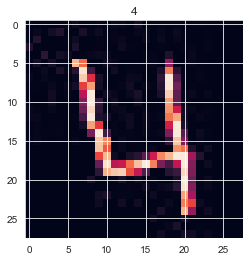

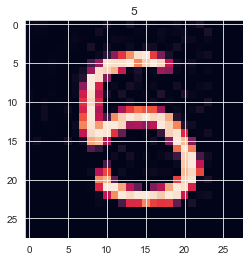

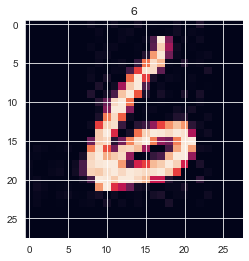

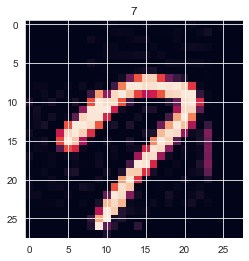

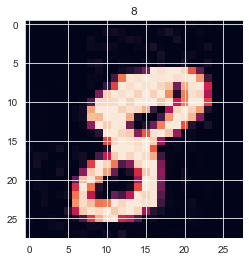

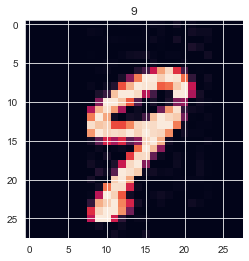

In [4]:
anchor = []

for i in range(len(train_dataset.data)):
    anchor.append(np.array(train_dataset.data[i][0]))
    plt.imshow(anchor[-1])
    plt.title(str(i))
    plt.show()

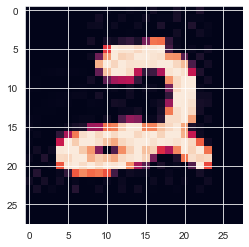

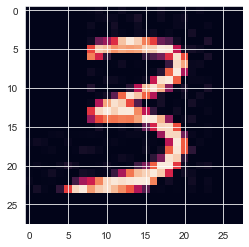

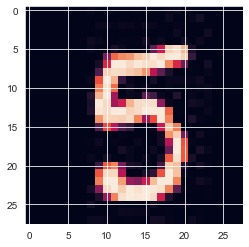

In [5]:
i = 0
for j in range(3):
    plt.imshow(test_dataset[j].reshape((28,28)).numpy())
    plt.show()

### 3.Creating a CNN-Siamese Model <a class="anchor" id="3"></a>

In [6]:
torch.cuda.empty_cache()

class siamese_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,32,3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32,64,3)
        self.pool2 = nn.MaxPool2d(2)
        self.l1 = nn.Linear(64*25,512)
        self.l2 = nn.Linear(512,1)
        
    def forward_N(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1,64*25)
        x = F.relu(self.l1(x))
        return x
    
    def forward(self,x1,x2):
        abs_val = torch.abs(self.forward_N(x1)-self.forward_N(x2))
        return torch.sigmoid(self.l2(abs_val))

    
device = 'cuda'

model = siamese_model()
model.to(device)
criterion = nn.BCELoss() # No need to add sigmoid
optimizer = optim.Adam(model.parameters(),lr = 0.00006)

epoch = 50000
loss_history = [[],[]]
accuracy_history = [[],[]]
train_n_minibatches = train_dataloader.__len__()

### 4.Training <a class="anchor" id="4"></a>

In [7]:
for e in range(epoch):
    for batch_idx , x in enumerate(train_dataloader):
        model.train() # Setting mode to train
        optimizer.zero_grad()
        x , y , z = x[0].to(device) , x[1].to(device) , x[2].to(device)
        y_pred = model(x,y)
        
        # Calculating Loss
        loss = criterion(y_pred,z)
        loss.backward()
        optimizer.step()
        loss_history[0].append(float(loss.detach()))
        
        #Calaculating Accuracy
        correct = 0
        y_pred = y_pred.cpu().detach().numpy().tolist()
        y = z.cpu().detach().numpy().tolist()
        for i,j in zip(y,y_pred):
            if round(j[0]) == int(i[0]):
                correct = correct + 1
        accuracy_history[0].append((correct/x.shape[0])*100)
        
#     torch.save(model.state_dict(),'saved_model/siamese_model')
    
    loss_history[1].append(sum(loss_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    accuracy_history[1].append(sum(accuracy_history[0][-1:-train_n_minibatches-1:-1])/train_n_minibatches)
    if (e+1)%2000 == 0:
    #Log for e+1th epoch
        print(f'---------------------------------------EPOCH {e+1}-------------------------------------------')
        print(f'Loss for EPOCH {e+1}  TRAIN LOSS : {loss_history[1][-1]}',end = ' ')
        print(f'TRAIN ACCURACY : {accuracy_history[1][-1]}')
        print(f'---------------------------------------------------------------------------------------------')

---------------------------------------EPOCH 2000-------------------------------------------
Loss for EPOCH 2000  TRAIN LOSS : 0.25676218047738075 TRAIN ACCURACY : 91.74107142857143
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 4000-------------------------------------------
Loss for EPOCH 4000  TRAIN LOSS : 0.24184377305209637 TRAIN ACCURACY : 93.30357142857143
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 6000-------------------------------------------
Loss for EPOCH 6000  TRAIN LOSS : 0.13915993180125952 TRAIN ACCURACY : 97.65625
---------------------------------------------------------------------------------------------
---------------------------------------EPOCH 8000-------------------------------------------
Loss for EPOCH 8000  TRAIN LOSS : 0.23444047570228577 TRAIN ACCURACY : 94.08482142857143

### 5.Plotting Graphs<a class="anchor" id="5"></a>

#### 1.Plotting Loss vs Epoch<a class="anchor" id="5.1"></a>

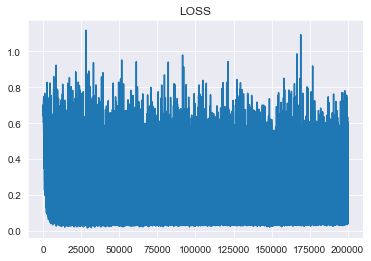

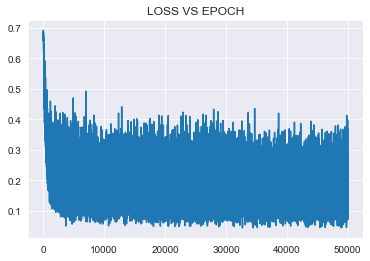

In [8]:
plt.plot(loss_history[0]) #[::int(len(loss_history[0])/300)])
plt.title('LOSS')
plt.show()

plt.plot(loss_history[1])
plt.title('LOSS VS EPOCH')
plt.show()

#### 2.Plotting Accuracy vs Epoch<a class="anchor" id="5.2"></a>

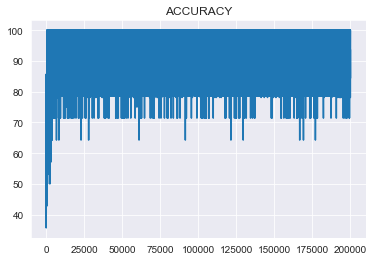

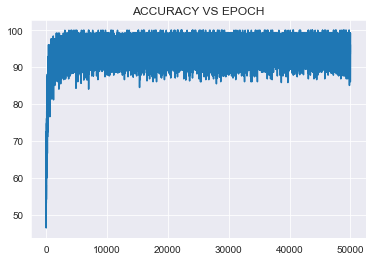

In [9]:
plt.plot(accuracy_history[0]) #[::int(len(accuracy_history[0])/300)])
plt.title('ACCURACY')
plt.show()

plt.plot(accuracy_history[1])
plt.title('ACCURACY VS EPOCH')
plt.show()

### 6.Loading and Testing<a class="anchor" id="6"></a>

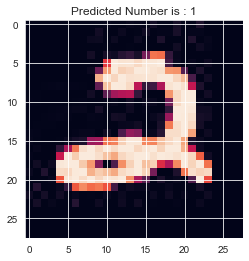

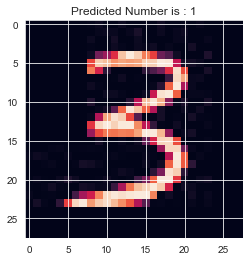

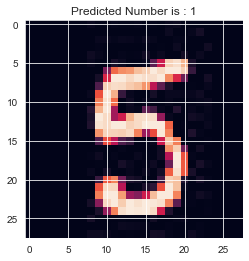

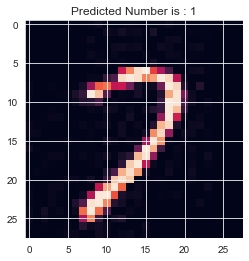

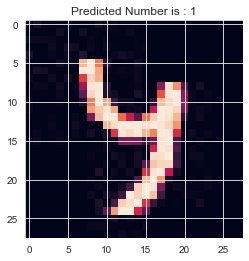

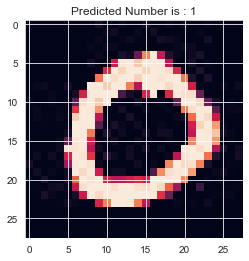

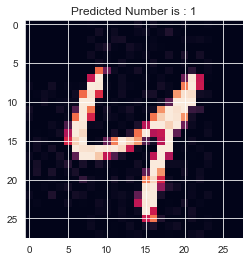

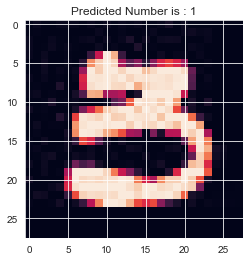

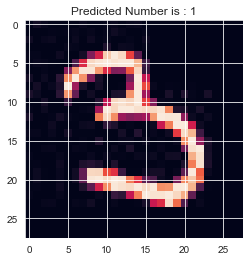

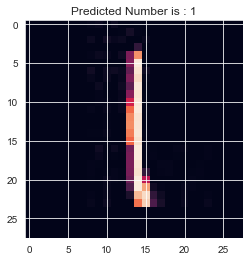

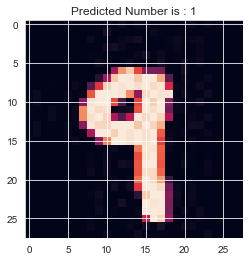

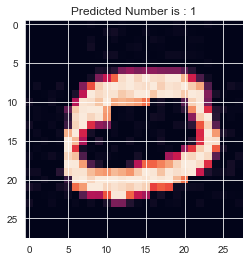

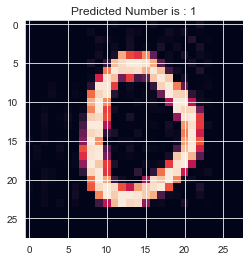

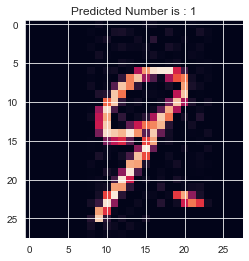

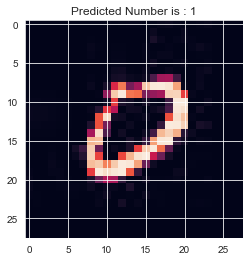

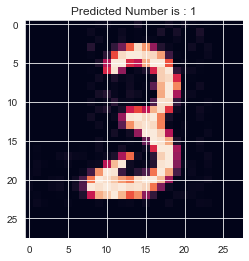

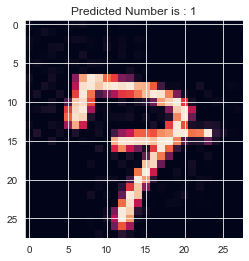

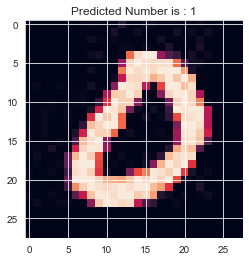

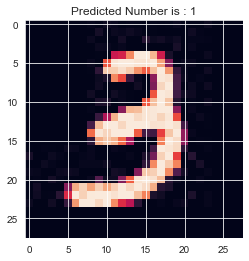

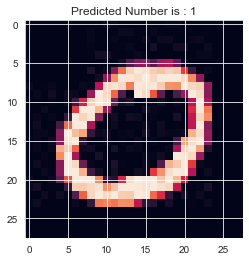

In [10]:
model = siamese_model()
model.load_state_dict(torch.load('saved_model/siamese_model'))
model.to(device)                              

prediction = []
for j in range(len(test_dataset)):
    temp = []
    for i in anchor:
        temp.append(model(test_dataset[j].reshape((1,1,28,28)).to(device),torch.FloatTensor(i).reshape((1,1,28,28)).to(device)).cpu().detach().numpy()[0][0])
    prediction.append(temp)
    
    plt.imshow(test_dataset[j].reshape((28,28)).numpy())
    plt.title('Predicted Number is : ' + str(temp.index(max(temp))))
    plt.show()


In [11]:
temp

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]